## Plot results of gene dosage experiments

Here, we're interested in exploring how much our predictions with gene expression data change when we do either of the following:

* Remove the target gene (gene whose mutations we are predicting) from the feature set ("drop target" experiments)
* Use only the expression of the target gene + non-gene covariates for prediction ("only target" experiments)

From these two experiments combined, we should be able to get a sense of how predictive changes to the dosage of the mutated gene are, and how redundant those changes are compared to other genes in the gene set.

We'll do this for the 15 best-predicted genes in our gene set.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'], 'dosage_effects')

In [3]:
# process all component experiments, explained above in bullet points
# control (all genes), drop_target (all genes except target), only_target
results_df = []
for subdir in results_dir.iterdir():
    experiment = subdir.stem
    gene_dir = Path(subdir, 'gene')
    model_results_df = au.load_stratified_prediction_results(gene_dir, 'gene')
    model_results_df['experiment'] = (
        experiment.replace('_', ' ').capitalize()
    )
    results_df.append(model_results_df)
    
results_df = pd.concat(results_df)
print(results_df.shape)
results_df.head()

(2160, 9)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.75778,0.74085,TP53,expression,shuffled,42,train,0,Drop target
1,0.73380,0.71366,TP53,expression,shuffled,42,test,0,Drop target
2,0.61896,0.58021,TP53,expression,shuffled,42,cv,0,Drop target
3,0.74560,0.72257,TP53,expression,shuffled,42,train,1,Drop target
4,0.71528,0.68853,TP53,expression,shuffled,42,test,1,Drop target


### Plot raw AUPR, with no correction for shuffled baseline

<AxesSubplot:xlabel='identifier', ylabel='aupr'>

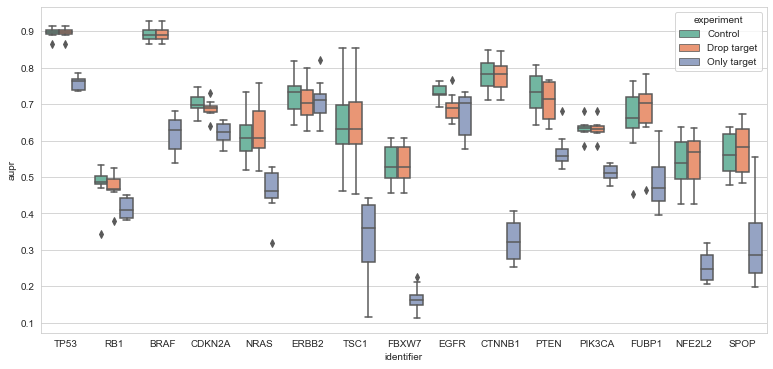

In [4]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

plot_df = results_df[((results_df.signal == 'signal') &
                      (results_df.data_type == 'test'))]
hue_order = [
    'Control',
    'Drop target',
    'Only target'
]
sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='experiment',
            hue_order=hue_order)

### Correct for shuffled baseline + plot signal AUPR - shuffled AUPR

In [5]:
# now correct for shuffled baseline
results_df = (results_df
    .drop(columns='training_data')
    .rename(columns={'experiment': 'training_data'})
)
all_results_df = au.compare_all_data_types(results_df,
                                           0.05,
                                           filter_genes=False,
                                           compare_ind=True)
all_results_df = all_results_df.rename(columns={'training_data': 'experiment'})
all_results_df.head()

,gene,seed,fold,delta_aupr,experiment
0,BRAF,1,0,0.34253,Drop target
1,BRAF,1,1,0.27114,Drop target
2,BRAF,1,2,0.27199,Drop target
3,BRAF,1,3,0.36277,Drop target
4,BRAF,42,0,0.29706,Drop target


<AxesSubplot:xlabel='gene', ylabel='delta_aupr'>

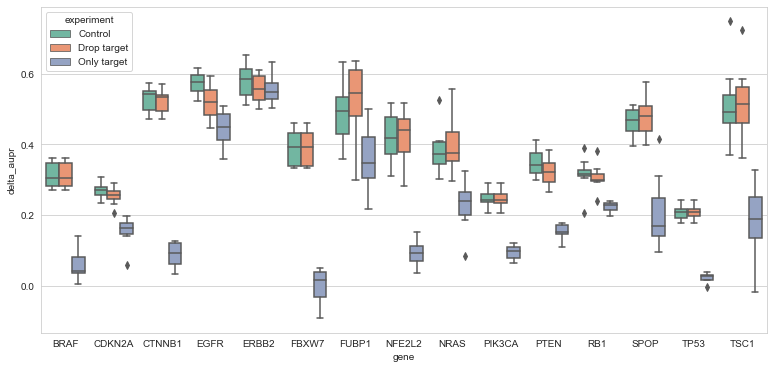

In [6]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

sns.boxplot(data=all_results_df, x='gene', y='delta_aupr', hue='experiment',
            hue_order=hue_order)

In [7]:
pivot_df = all_results_df.pivot(index=['gene', 'seed', 'fold'],
                                columns='experiment',
                                values='delta_aupr')
pivot_df.head(10)

experiment        Control  Drop target  Only target
gene   seed fold                                   
BRAF   1    0     0.34253      0.34253      0.07584
            1     0.27114      0.27114      0.09841
            2     0.27199      0.27199      0.03799
            3     0.36277      0.36277      0.00689
       42   0     0.29706      0.29706      0.04475
            1     0.31314      0.31314      0.03953
            2     0.28605      0.28605      0.03614
            3     0.36008      0.36008      0.14200
CDKN2A 1    0     0.26595      0.25414      0.05857
            1     0.27578      0.26027      0.15374

In [8]:
pivot_df['Control - drop target'] = pivot_df.Control - pivot_df['Drop target']
pivot_df['Control - only target'] = pivot_df.Control - pivot_df['Only target']

pivot_df = (pivot_df
  .drop(columns='Control')
  .reset_index()
  .melt(id_vars=['gene', 'seed', 'fold'],
        value_vars=['Control - drop target', 'Control - only target'],
        value_name='delta_aupr')
)

pivot_df.head()

,gene,seed,fold,experiment,delta_aupr
0,BRAF,1,0,Control - drop target,0.0
1,BRAF,1,1,Control - drop target,0.0
2,BRAF,1,2,Control - drop target,0.0
3,BRAF,1,3,Control - drop target,0.0
4,BRAF,42,0,Control - drop target,0.0


<AxesSubplot:xlabel='gene', ylabel='delta_aupr'>

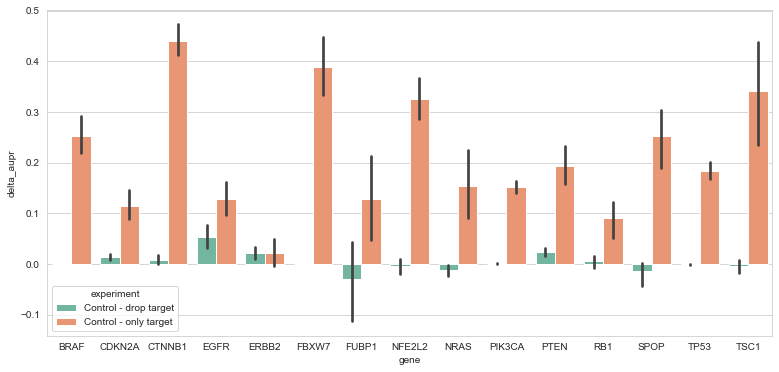

In [9]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

hue_order = [
    'Control - drop target',
    'Control - only target'
]
sns.barplot(data=pivot_df, x='gene', y='delta_aupr', hue='experiment',
            hue_order=hue_order)

In the above plot, we would expect the following:

* Dosage of target gene provides lots of non-redundant info: (control - drop target) large, (control - only target) small
* Dosage of target gene provides little non-redundant info: (control - drop target) small, (control - only target) large

In most cases we seem to see the latter, suggesting that expression of the target gene alone doesn't provide that much information, and that the information it does provide is highly redundant.

For EGFR and ERBB2, we see that (control - drop target) is slightly larger and (control - only target) is slightly smaller, suggesting that the expression of these genes provides more non-redundant information about their mutation status than the others. Both of these genes are [receptor tyrosine kinases, or RTKs](https://en.wikipedia.org/wiki/Receptor_tyrosine_kinase) - not sure why these would behave differently than the other genes we looked at, though.